# Food Classification Model
### Introduction

We implemented an image classification model to classify a set 10 food items. The model uses the ResNet-50 architecture pre-trained on ImageNet database is train via transfer learing. The dataset this model was trained on is composed of between 3000 images of a 10 standalone food items scraped from various sources (Pinterest, tumblr, reddit, etc). Each category is composed of 300 images to keep the dataset balanced. Categories of food included in this dataset are:
- Cheeseburger
- Cake
- Cookie
- Fries
- Hotdog
- Pizza
- Salad
- Shrimp
- Steak
- Sushi

The dataset is split into seperate subfolders by type of food and folders are named after their respective food items. The Image dataset is available for download [here.](https://drive.google.com/file/d/1eeGF1GQc97_YIwdqewt6nPmob1bNr7M5) Make sure to extract and save the dataset folder in the same directory as this file before you begin training. 


### Preprocessing

In order to prepare our dataset for training we must preprocess our images to before we begin training. Preprocessing includes transforming the images into tensors, resizing their dimensions to 224x224, and normalizing the input data. 
- Our images are represented by tensors of shape (C x H x W) where C is the number of channels (3 for RGB images, 1 for grayscale), H is the height of the image, and W is the width. 
- Resizing our images to 224 x 224 is to make that the image fits the input shape that ResNet50 was originally trained on. 
- We normalize the input images using the same mean and standard deviation of ImageNet, which helps the model to perform better on the input images.



In [26]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

data_transforms = transforms.Compose([
transforms.Resize((224, 224), antialias=True),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='dataset', transform=data_transforms)
classes = dataset.classes

### Spliting the dataset 

Our dataset is then split into train (70%), validation (10%), and test (20%) sets which are randomly split to make sure that each set has a representative number of images for each food item. We then created dataloaders for each set with a batch size of 32.

In [27]:
import torch
from torch.utils.data import random_split, DataLoader

batch_size = 32

# Split the dataset into train, validation, and test sets using random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.7*len(dataset)), int(0.1*len(dataset)), int(0.2*len(dataset))])

# Create data loaders for training, validation, and test sets with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Loading pre-trained model

We then load the ResNet50 model pretrained on the ImageNet, freezed all pre-trained layers of the original model, replaced final layer of resnet50 with a new layer that has the same number of inputs and 10 outputs for our food categories

In [28]:
import torch.nn as nn
import torchvision.models as models

# Load the pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze the parameters of the pretrained model
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
num_classes = len(dataset.classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/hoanngo/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 52.6MB/s]


### Optimizer and Criterion

We used a stochastic gradient descent optimizer for final training layer, with a learn rate of 0.001 and a momentum coeffcient of 0.9 (to avoid getting trapped in local minima), and used cross-entropy loss as our loss function. If the GPU is not available for training, it will default to the CPU.

In [29]:
# Define learning rate and momentum
learn_rate = 0.001
momentum = 0.9

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the optimizer with stochastic gradient descent
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=learn_rate, momentum=momentum)

# Define the loss function as Cross Entropy Loss
criterion = torch.nn.CrossEntropyLoss()


### Training and Validation

Our Training and Validation are set to run for 10 epochs. During training, our optimizer's gradients are set to zero at the start of each batch, Then the forward pass feeds batch input into the model returns output probilities(10 for each food item). The criterion finds the loss between the model's output and the true label,and back-propagates to computes the gradients of the loss(so we can record them later). The optimizer updates the model using the gradients. Our loss, accuracy, predictions and ground-truths is recorded at the end of each batch.

During Validation, we perform a forward pass on each batch in the Valdation set and calculate and record the loss, accuracy, predictions and ground-truths of each batch.

In [30]:
num_epochs = 10

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Training
    resnet50.train()  # Puts the model to train mode
    train_loss, train_correct, train_total = 0, 0, 0
    train_y_pred, train_y_true = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        train_total += labels.size(0)

        train_y_pred += preds.tolist()
        train_y_true += labels.tolist()

    train_loss /= train_total
    train_acc = train_correct.double() / train_total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    resnet50.eval()  # Puts the model to evaluation mode
    val_loss, val_correct, val_total = 0, 0, 0
    val_y_pred, val_y_true = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
            val_total += labels.size(0)

            val_y_pred += preds.tolist()
            val_y_true += labels.tolist()

    val_loss /= val_total
    val_acc = val_correct.double() / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print('Epoch %d: Training Loss: %.4f, Training Acc: %.4f Validation Loss: %.4f, Valiation Acc: %.4f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc))


Epoch 1: Training Loss: 1.6290, Training Acc: 0.6029 Validation Loss: 0.9469, Valiation Acc: 0.8767
Epoch 2: Training Loss: 0.7280, Training Acc: 0.9095 Validation Loss: 0.5852, Valiation Acc: 0.9167
Epoch 3: Training Loss: 0.5031, Training Acc: 0.9238 Validation Loss: 0.4481, Valiation Acc: 0.9267
Epoch 4: Training Loss: 0.4100, Training Acc: 0.9357 Validation Loss: 0.3844, Valiation Acc: 0.9333
Epoch 5: Training Loss: 0.3496, Training Acc: 0.9448 Validation Loss: 0.3350, Valiation Acc: 0.9500
Epoch 6: Training Loss: 0.3101, Training Acc: 0.9481 Validation Loss: 0.2988, Valiation Acc: 0.9533
Epoch 7: Training Loss: 0.2807, Training Acc: 0.9519 Validation Loss: 0.2732, Valiation Acc: 0.9467
Epoch 8: Training Loss: 0.2528, Training Acc: 0.9557 Validation Loss: 0.2592, Valiation Acc: 0.9533
Epoch 9: Training Loss: 0.2379, Training Acc: 0.9543 Validation Loss: 0.2379, Valiation Acc: 0.9600
Epoch 10: Training Loss: 0.2224, Training Acc: 0.9538 Validation Loss: 0.2310, Valiation Acc: 0.9533

### Training and Validation Results

Once training and valdation are complete, we calculate our total loss, accuracy, and class-wise accuracy for both training and validation sets

In [33]:
import numpy as np

def get_class_accuracy(y_true, y_pred, num_classes):
    class_counts = np.bincount(y_true, minlength=num_classes)
    class_correct = np.zeros(num_classes)
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            class_correct[y_true[i]] += 1
    
    class_acc = (class_correct / class_counts)
    
    return class_acc


In [34]:
# Calculate class accuracies for training and validation data
metrics = {
    'train': {
        'loss': train_loss,
        'accuracy': train_acc,
        'class_acc': get_class_accuracy(y_true=train_y_true, y_pred=train_y_pred, num_classes=num_classes)
    },
    'val': {
        'loss': val_loss,
        'accuracy': val_acc,
        'class_acc': get_class_accuracy(y_true=val_y_true, y_pred=val_y_pred, num_classes=num_classes)
    }
}

# Print metrics for training and validation data
print("\n\nTraining and Validation Complete!")
print("----------------------------------------------")
print(f"Number of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning rate: {learn_rate:.3f}")
print("----------------------------------------------")
for metric_type, metric_values in metrics.items():
    print(f"\nTotal {metric_type.capitalize()}ing Loss: {metric_values['loss']:.4f}")
    print(f"Total {metric_type.capitalize()}ing Accuracy: {metric_values['accuracy']:.2%}")
    print("----------------------------------------------")
    print(f"\n{metric_type.capitalize()}ing Class-wise Accuracy")
    print("----------------------------------------------")
    for i in range(num_classes):
        print(f"\"{classes[i]}\" Accuracy: {metric_values['class_acc'][i]:.2%}")
    print("----------------------------------------------")




Training and Validation Complete!
----------------------------------------------
Number of Epochs: 10
Batch Size: 32
Learning rate: 0.001
----------------------------------------------

Total Training Loss: 0.2224
Total Training Accuracy: 95.38%
----------------------------------------------

Training Class-wise Accuracy
----------------------------------------------
"burger" Accuracy: 97.20%
"cake" Accuracy: 94.81%
"cookie" Accuracy: 96.31%
"fries" Accuracy: 92.42%
"hotdog" Accuracy: 93.33%
"pizza" Accuracy: 96.30%
"salad" Accuracy: 97.51%
"shrimp" Accuracy: 95.45%
"steak" Accuracy: 96.37%
"sushi" Accuracy: 94.12%
----------------------------------------------

Total Valing Loss: 0.2310
Total Valing Accuracy: 95.33%
----------------------------------------------

Valing Class-wise Accuracy
----------------------------------------------
"burger" Accuracy: 100.00%
"cake" Accuracy: 100.00%
"cookie" Accuracy: 100.00%
"fries" Accuracy: 93.75%
"hotdog" Accuracy: 93.94%
"pizza" Accuracy: 9

### Plotting the Data

We use our save prediction and ground-truths to calculate confusion matricies for our train and validation set and plot train and validation curves

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def plot_confusion_matrix(cm, num_classes, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in product(range(num_classes), range(num_classes)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


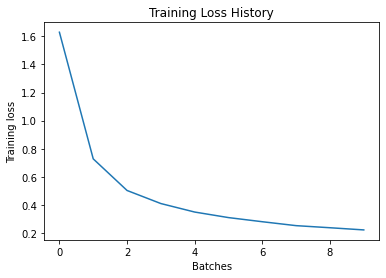

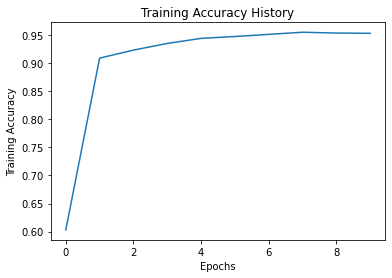

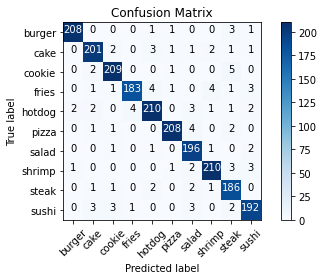

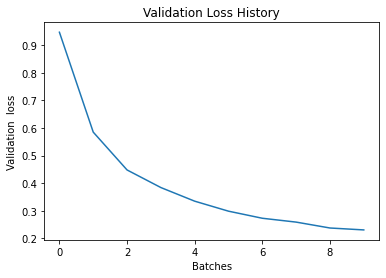

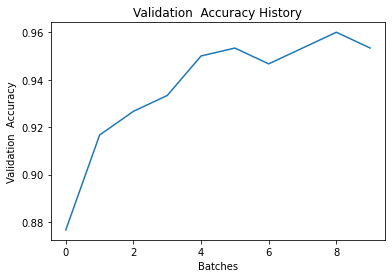

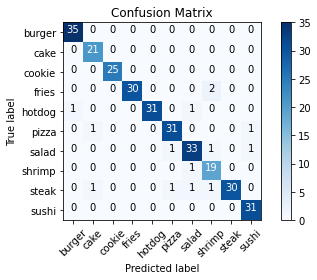

<Figure size 432x288 with 0 Axes>

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

train_cm = confusion_matrix(y_true=train_y_true,y_pred=train_y_pred)
val_cm = confusion_matrix(y_true=val_y_true,y_pred=val_y_pred)

plt.plot(train_loss_history)
plt.title('Training Loss History')
plt.xlabel('Batches')
plt.ylabel('Training loss')
plt.show()

plt.clf()

plt.plot(train_acc_history)
plt.title('Training Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()

plt.clf()

plot_confusion_matrix(train_cm, num_classes, classes)
plt.show()

plt.plot(val_loss_history)
plt.title('Validation Loss History')
plt.xlabel('Batches')
plt.ylabel('Validation  loss')
plt.show()

plt.clf()

plt.plot(val_acc_history)
plt.title('Validation  Accuracy History')
plt.xlabel('Batches')
plt.ylabel('Validation  Accuracy')
plt.show()

plt.clf()

plot_confusion_matrix(val_cm, num_classes, classes)
plt.show()

plt.clf()


### Testing

Our model is then tested using of test set(20% of the orginal dataset) we made earlier, calculate the total loss, accuracy, and class-wise accuracy of the test set as well as plotting a confusion matrix between the models prediction and ground-truthes

Starting Testing...

---------------------------------------------
Batch Size: 32
---------------------------------------------

Batch 1: Test Loss: 0.0112, Test Acc: 0.0533
Batch 2: Test Loss: 0.0056, Test Acc: 0.1050
Batch 3: Test Loss: 0.0231, Test Acc: 0.1517
Batch 4: Test Loss: 0.0077, Test Acc: 0.2033
Batch 5: Test Loss: 0.0081, Test Acc: 0.2533
Batch 6: Test Loss: 0.0083, Test Acc: 0.3050
Batch 7: Test Loss: 0.0101, Test Acc: 0.3583
Batch 8: Test Loss: 0.0113, Test Acc: 0.4100
Batch 9: Test Loss: 0.0083, Test Acc: 0.4617
Batch 10: Test Loss: 0.0082, Test Acc: 0.5133
Batch 11: Test Loss: 0.0099, Test Acc: 0.5650
Batch 12: Test Loss: 0.0110, Test Acc: 0.6183
Batch 13: Test Loss: 0.0132, Test Acc: 0.6683
Batch 14: Test Loss: 0.0114, Test Acc: 0.7217
Batch 15: Test Loss: 0.0238, Test Acc: 0.7650
Batch 16: Test Loss: 0.0148, Test Acc: 0.8150
Batch 17: Test Loss: 0.0136, Test Acc: 0.8633
Batch 18: Test Loss: 0.0077, Test Acc: 0.9167
Batch 19: Test Loss: 0.0046, Test Acc: 0.9567


Test

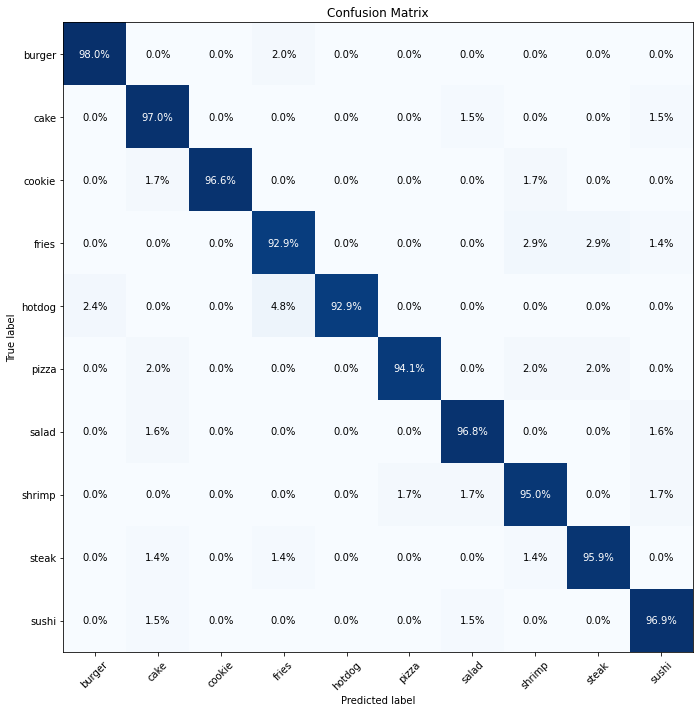

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, num_classes, classes):
    fig, ax = plt.subplots(figsize=(num_classes,num_classes))
    im = ax.imshow(cm, cmap='Blues')

    # Add title and axis labels
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Add class labels to the axes ticks
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    # Add percentages to the confusion matrix cells
    thresh = cm.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, format(cm[i, j], '.1f') + '%', ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.savefig("confusion_matrix.png")

y_pred = []
y_true = []

print("Starting Testing...")
print("\n---------------------------------------------")
print("Batch Size: %d" % batch_size)
print("---------------------------------------------\n")

#Test
resnet50.eval()
test_loss = 0
test_correct = 0
batch_count = 0
with torch.no_grad():
        for inputs, labels in test_loader:
            batch_count+=1
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels.data)

            y_pred+=[int(tensor) for tensor in preds]
            y_true+=[int(tensor) for tensor in labels.data]

            test_loss = test_loss / len(test_loader.dataset)
            test_acc = test_correct.double() / len(test_loader.dataset)

            print('Batch %d: Test Loss: %.4f, Test Acc: %.4f' % (batch_count,test_loss, test_acc))

# Calculate confusion matrix
cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
cm = np.round((cm / cm.sum(axis=1)[:, np.newaxis]) * 100, 1) # Convert counts to percentages and round to 1 decimal digit

class_acc = get_class_accuracy(y_true=y_true, y_pred=y_pred,num_classes=num_classes)


print("\n\nTesting Complete!")
print("\nTest Summary")
print("----------------------------------------------")
print("Batch Size: %d" % batch_size)

print("\nTotal Test Loss: %.4f" % test_loss)
print("Total Test Accuracy: %.2f%%" % (test_acc*100))
print("----------------------------------------------")
print("\nClass-wise Accuracy")
print("----------------------------------------------")
for i in range(num_classes):
    print("\"%s\" Accuracy: %.2f%%" % (classes[i], class_acc[i]*100))
print("----------------------------------------------")

print("\nPlotting Test data...")

#Makes and saves a confusion matrix
plot_confusion_matrix(cm, num_classes, classes)
plt.show()
